# Importing Libraries and Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.geometry import MultiPoint
from shapely.ops import linemerge

import os
import shutil
from pathlib import Path
from PIL import Image

import torch
from torchvision import models
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from torchvision.models import VGG16_Weights
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from collections import Counter

In [2]:
# Load data from the London_UK folder.
data_path = Path('London_UK')

panoids = gpd.read_file(data_path / 'panoids/panoids.geojson')
streets = gpd.read_file(data_path / 'network/edges/edges.geojson')

# Splitting road network

In this step, the road network is split in smaller segments to later be classified.

In [3]:
# Define the function that splits the larger initial network LineStrings in segments no bigger than 50 metres.
def split_line(line, max_segment_length=50):
    # Calculate the number of segments
    num_segments = int(line.length // max_segment_length) + 1
    segment_length = line.length / num_segments
    
    # Create a list to store the segments
    segments = []
    
    # Generate points along the line at each segment length
    for i in range(num_segments):
        start_point = line.interpolate(i * segment_length)
        end_point = line.interpolate(min((i + 1) * segment_length, line.length))
        segment = LineString([start_point, end_point])
        segments.append(segment)
    
    return segments

# Re-project to a suitable CRS if necessary
if streets.crs.is_geographic:
    streets = streets.to_crs(epsg=27700)  # 27700 is the most suited for Great Britain

# Calculate lengths
streets['length'] = streets.length

# Split lines longer than 100 meters
split_segments = []
for _, row in streets.iterrows():
    if row['length'] > 100:
        split_segments.extend(split_line(row['geometry'], max_segment_length=50))
    else:
        split_segments.append(row['geometry'])

# Create a new GeoDataFrame with the split segments
split_streets_gdf_max = gpd.GeoDataFrame(geometry=split_segments, crs=streets.crs)

# Calculate the new lengths
split_streets_gdf_max_L = split_streets_gdf_max.length

split_streets_gdf_max['length'] = split_streets_gdf_max_L


In [4]:
# Function to merge all new LineStings smaller than 10 metres.
def merge_short_lines(streets_gdf, min_total_length=50, max_individual_length=10):
    merged_segments = []
    current_merge = []

    for _, row in streets_gdf.iterrows():
        line = row['geometry']
        line_length = line.length

        if line_length < max_individual_length:
            current_merge.append(line)
            total_length = sum([seg.length for seg in current_merge])

            if total_length >= min_total_length:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
        else:
            if current_merge:
                merged_line = linemerge(current_merge)
                merged_segments.append(merged_line)
                current_merge = []
            merged_segments.append(line)

    # If there are any remaining lines in the current merge, add them
    if current_merge:
        merged_line = linemerge(current_merge)
        merged_segments.append(merged_line)

    return gpd.GeoDataFrame(geometry=merged_segments, crs=streets_gdf.crs)

# Merge short lines
merged_streets_gdf = merge_short_lines(split_streets_gdf_max)

# Optionally, calculate the new lengths
merged_streets_gdf['length'] = merged_streets_gdf.length


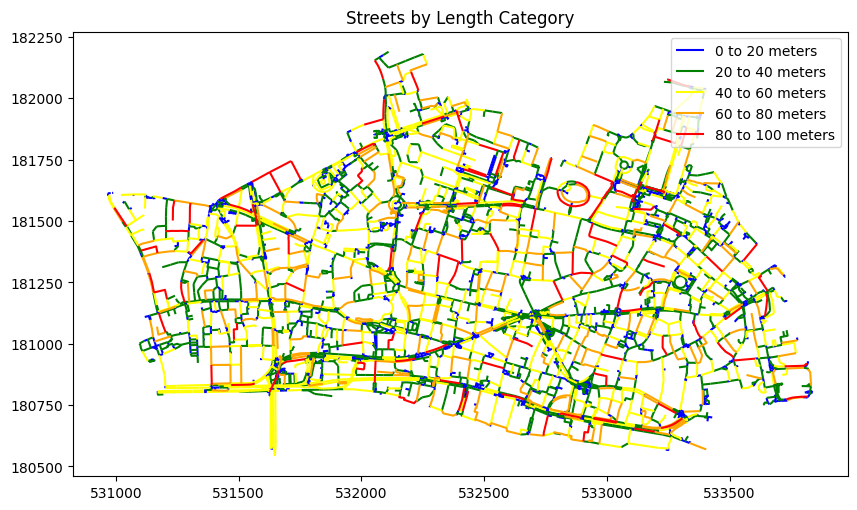

In [5]:
# Define a function to categorize lengths and assign colors
def categorize_and_plot(gdf):
    # Define the bins and corresponding colors
    bins = [0, 20, 40, 60, 80, 100]
    colors = ['blue', 'green', 'yellow', 'orange', 'red']
    
    # Create a new column 'category' based on the length
    gdf['category'] = np.digitize(gdf['length'], bins, right=True)
    
    # Plot each category with a different color
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, color in enumerate(colors, start=1):
        category_gdf = gdf[gdf['category'] == i]
        if not category_gdf.empty:
            category_gdf.plot(ax=ax, color=color, label=f'{bins[i-1]} to {bins[i]} meters')
    
    plt.title('Streets by Length Category')
    plt.legend()
    plt.show()

# Call the function to categorize and plot
categorize_and_plot(merged_streets_gdf)

# Associating images with street segments

In [29]:
# Creates a panoids GeoDataFrame
panoids_gdf = gpd.GeoDataFrame(
    panoids,
    geometry=[Point(xy) for xy in zip(panoids['lng'], panoids['lat'])],
    crs='EPSG:4326'  # Assuming WGS 84
)

# Ensure both GeoDataFrames are in the same CRS
if merged_streets_gdf.crs != panoids_gdf.crs:
    panoids_gdf = panoids_gdf.to_crs(merged_streets_gdf.crs)

# Ensure the GeoDataFrame is in a projected CRS for accurate buffer calculations
if merged_streets_gdf.crs.is_geographic:
    merged_streets_gdf = merged_streets_gdf.to_crs(epsg=27700)  # Example: British National Grid
    
# Create a buffer of 20 meters around each LineString
merged_streets_gdf['buffer'] = merged_streets_gdf.geometry.buffer(20)

# Perform a spatial join to find which panoids fall within the buffer
panoids_in_buffer = gpd.sjoin(panoids_gdf, merged_streets_gdf.set_geometry('buffer'), how='inner', predicate='within')

# Group by the index of the LineString and aggregate panoids
linestring_panoids = panoids_in_buffer.groupby('index_right')['panoid'].apply(list).reset_index()

C:\Users\yigit\AppData\Local\Temp\ipykernel_6488\788597189.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


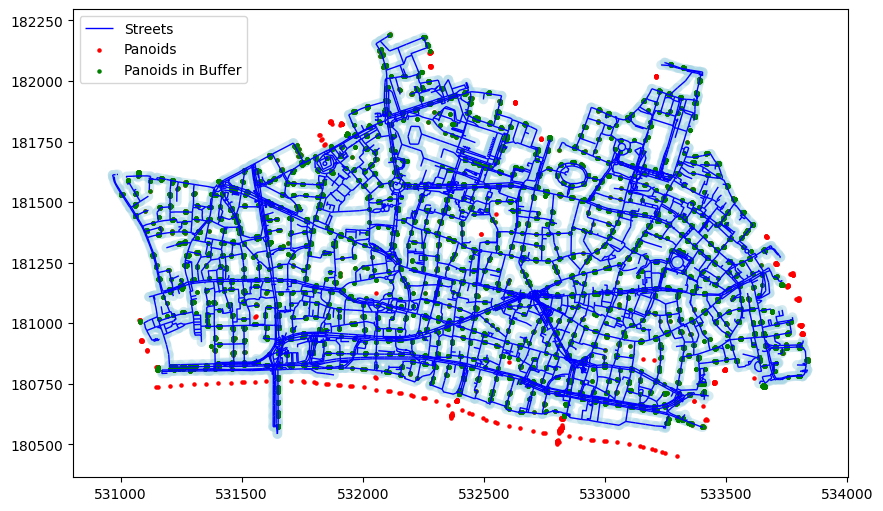

In [30]:
# Visualize the data
fig, ax = plt.subplots(figsize=(10, 10))
merged_streets_gdf.plot(ax=ax, color='blue', linewidth=1, label='Streets')
merged_streets_gdf['buffer'].plot(ax=ax, color='lightblue', alpha=0.5, label='Buffer (20m)')
panoids_gdf.plot(ax=ax, color='red', markersize=5, label='Panoids')
panoids_in_buffer.plot(ax=ax, color='green', markersize=5, label='Panoids in Buffer')
plt.legend()
plt.show()

In [46]:
import pandas as pd

# Example DataFrames
# Assuming panoids DataFrame has a 'panoid' column
# panoids = pd.DataFrame({
#     'panoid': ['wFmLm4GhS7AYVonj6tRIJw', 'ITjfv5l9KG5ImWa7eTOzAw', 'xdou9yN5jG9HVTpAHFIKNA', ...]
# })

# Assuming linestring_panoids DataFrame has a 'panoid' column with lists of panoids
# linestring_panoids = pd.DataFrame({
#     'index_right': [5, 6, 5031, 5033],
#     'panoid': [['xdou9yN5jG9HVTpAHFIKNA'], ['Ym72WsFbvhBpr0D19DxasA', 'xdou9yN5jG9HVTpAHFIKNA'], ['L2RO_RaCf8L8fMwryPqJ9Q'], ['L2RO_RaCf8L8fMwryPqJ9Q', 'zvFAL1gCIrKxLBA6AhLM-']]
# })

# Create a mapping from panoid to index
panoid_to_index = {panoid: index for index, panoid in enumerate(panoids['panoid'])}

# Function to convert panoid list to index list
def convert_panoid_to_index(panoid_list):
    return [panoid_to_index.get(panoid, -1) for panoid in panoid_list]  # Use -1 for panoids not found

# Apply the conversion to the 'panoid' column
linestring_panoids['panoid_index'] = linestring_panoids['panoid'].apply(convert_panoid_to_index)

# Print the updated DataFrame
print(linestring_panoids)

      index_right                                             panoid  \
0               5                           [xdou9yN5jG9HVTpAHFIKNA]   
1               6   [Ym72WsFbvhBpr0D19DxasA, xdou9yN5jG9HVTpAHFIKNA]   
2               8                           [xdou9yN5jG9HVTpAHFIKNA]   
3               9  [xHxCUvX5chMOydy9WdcHRA, g6G6Rza4wCHAFyyGH1lF0...   
4              10  [DW0rSBghzK_zKlEqzFS07w, hO7nswlVtu2Qa9I2y0oLN...   
...           ...                                                ...   
4290         5025  [VgB1-T_mMoImrsdbc9pAZA, ruQvGAcacOZK2SC3zwoKT...   
4291         5026  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4292         5027  [7J9WBdGzbtCgxIEvdvOQLA, aFng_NDdLw5gnmuWuEoNl...   
4293         5028  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   
4294         5030  [L2RO_RaCf8L8fMwryPqJ9Q, zvFAL1gCIrKxLBA6AhLM-...   

                                           panoid_index  
0                                                [4614]  
1                  

# Model

## Categorizing manually classified data

In [123]:
# Base directory where the subdirectories are located
base_dir = Path(r'\\tudelft.net\staff-umbrella\imagesummary\STREET\London_UK\imagedb')

# Define the subdirectories and their corresponding image lists with the manually classified panoids
categories = {
    'residential_road': [
        "410_s_a", "410_f", "410_s_b", "410_b", "417_s_a", "417_s_b", "568_s_a", "568_f", "568_s_b", "619_f",
        "619_s_b", "619_b", "754_f", "754_s_b", "754_b", "806_s_a", "806_f", "806_s_b", "806_b", "981_f",
        "981_b", "1116_s_a", "1116_f", "1116_s_b", "1116_b", "1430_s_a", "1430_f", "1430_s_b", "1430_b",
        "1465_s_b", "1750_s_a", "1750_f", "1750_s_b", "1750_b", "2166_s_a", "2497_f", "2497_b", "3235_s_a",
        "3235_f", "3235_s_b", "3235_b", "3264_f", "3264_b", "3757_s_a", "3757_f", "3757_s_b", "3757_b",
        "3797_s_a", "3797_f", "3797_s_b", "3797_b", "3852_f", "3852_s_b", "3852_b", "4142_s_a", "4142_f",
        "4142_s_b", "4142_b", "4187_s_a", "4187_f", "4187_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4810_s_a", "4810_f", "4880_s_a", "4880_f", "4880_s_b", "4880_b", "4985_s_a", "5074_s_a", "5074_f",
        "5074_s_b", "5079_f", "5079_b", "5136_s_a", "5136_f", "5136_s_b", "5136_b", "5160_f", "5160_b",
        "5338_s_a", "5338_f", "5338_s_b", "5338_b", "5379_s_a", "5379_s_b", "5869_f", "5869_s_b", "5869_b",
        "6417_s_a", "6417_f", "6417_s_b", "6417_b", "7028_f", "7028_b", "7039_f", "7039_b", "7486_f",
        "7486_b", "7795_s_a", "7795_f", "7795_b", "7822_s_a", "7822_f", "7822_s_b", "7822_b", "8285_f",
        "8324_s_a", "8324_s_b", "8346_s_a", "8346_f", "8346_s_b", "8346_b", "8435_s_a", "8435_f", "8435_s_b",
        "8435_b", "8594_s_a", "8594_f", "8594_s_b", "8594_b"
    ],
    'main_road': [
        "148_s_a", "148_f", "148_s_b", "148_b", "417_f", "417_b", "466_s_a", "466_f", "466_s_b", "466_b",
        "504_s_a", "504_f", "504_s_b", "504_b", "568_b", "582_s_a", "582_s_b", "582_b", "590_f", "590_s_b",
        "590_b", "811_s_a", "811_f", "811_b", "940_f", "940_s_b", "940_b", "946_s_a", "946_f", "946_s_b",
        "946_b", "1302_s_a", "1302_b", "1334_f", "1334_b", "1465_f", "1465_b", "1568_s_a", "2145_f", "2145_s_b",
        "2145_b", "2166_f", "2166_b", "2206_s_a", "2206_f", "2206_s_b", "2206_b", "2281_s_a", "2281_f", "2281_s_b",
        "2281_b", "2410_s_a", "2410_f", "2410_s_b", "2980_f", "2980_b", "2991_s_a", "2991_f", "2991_s_b", "2999_s_a",
        "2999_f", "2999_s_b", "2999_b", "3310_s_a", "3310_f", "3310_s_b", "3310_b", "3456_f", "3456_s_b", "3456_b",
        "3640_s_a", "3640_f", "3640_b", "3759_s_a", "3759_f", "3759_s_b", "3759_b", "3836_s_a", "3836_f", "3836_s_b",
        "3836_b", "4003_f", "4003_s_b", "4003_b", "4010_f", "4010_b", "4090_s_a", "4090_f", "4090_s_b", "4090_b",
        "4356_s_a", "4356_f", "4356_s_b", "4356_b", "4527_s_a", "4527_f", "4527_s_b", "4527_b", "4551_s_a", "4551_f",
        "4551_b", "4679_s_a", "4679_f", "4679_s_b", "4679_b", "4699_s_a", "4699_f", "4699_s_b", "4699_b", "4724_s_a",
        "4724_f", "4724_s_b", "4724_b", "4768_f", "4768_s_b", "4768_b", "4787_s_a", "4787_f", "4787_s_b", "4787_b",
        "4985_s_a", "4985_f", "4985_s_b", "4985_b", "5190_s_a", "5190_f", "5190_s_b", "5190_b", "5379_s_a", "5379_f",
        "5379_b", "5411_s_a", "5411_f", "5411_b", "6125_f", "6125_b", "6558_f", "6558_b", "6793_s_a", "6793_f",
        "6793_s_b", "6793_b", "6954_s_a", "6954_f", "6954_s_b", "6985_s_a", "6985_f", "6985_s_b", "6985_b", "7062_s_a",
        "7062_f", "7062_s_b", "7062_b", "7074_f", "7074_s_b", "7074_b", "7155_s_a", "7155_f", "7155_s_b", "7155_b",
        "7499_b", "7715_s_a", "7715_f", "7715_s_b", "7715_b", "7973_f", "7973_b", "8009_s_a", "8009_f", "8009_s_b",
        "8009_b", "8285_s_b", "8285_b", "8324_s_a", "8324_f", "8324_s_b", "8324_b", "8391_s_a", "8391_f", "8391_s_b",
        "8971_s_a", "8971_f", "8971_s_b", "8971_b"
    ],
    'pedestrian_road': [
        "582_f", "590_s_a", "619_s_a", "619_s_b", "754_s_a", "754_b", "806_s_a", "806_f", "806_s_b", "806_b",
        "811_s_b", "940_s_a", "981_s_a", "981_s_b", "1263_s_a", "1263_f", "1263_s_b", "1263_b", "1302_f", "1302_s_b",
        "1334_s_a", "1334_s_b", "1465_s_a", "1465_s_b", "1485_s_a", "1485_f", "1485_s_b", "1485_b", "1568_f", "1568_s_b",
        "1568_b", "2145_s_a", "2166_s_b", "2410_b", "2497_s_b", "2980_s_a", "2980_s_b", "2991_b", "3264_s_a", "3264_s_b",
        "3456_s_a", "3640_s_b", "3852_s_a", "4003_s_a", "4010_s_a", "4010_s_b", "4187_s_a", "4187_s_b", "4551_s_b",
        "4768_s_a", "4810_s_a", "4810_b", "5074_b", "5079_s_a", "5079_s_b", "5160_s_a", "5160_s_b", "5338_s_a", "5338_s_b",
        "5411_s_b", "5869_s_a", "6125_s_a", "6125_s_b", "6558_s_a", "6558_s_b", "6954_b", "6955_s_a", "6955_f", "6955_s_b",
        "6955_b", "7028_s_a", "7028_s_b", "7039_s_a", "7039_s_b", "7074_s_a", "7166_s_a", "7166_f", "7166_s_b", "7166_b",
        "7486_s_a", "7486_s_b", "7499_s_a", "7499_f", "7499_s_b", "7795_s_b", "7973_s_a", "7973_s_b", "8285_s_a", "8285_f",
        "8391_b", "8709_s_a", "8709_f", "8709_s_b", "8709_b", "8784_s_a", "8784_f", "8784_s_b", "8784_b"
    ]
}

# Destination directory to save images into subfolders
destination_dir = Path('classified_data')

# Create DataFrames and copy images to respective subfolders
for category, filenames in categories.items():
    # Construct the full path for each image
    image_paths = [os.path.join(base_dir, f"image_{filename}.png") for filename in filenames]
    
    # Create the subfolder if it doesn't exist
    category_path = os.path.join(destination_dir, category)
    os.makedirs(category_path, exist_ok=True)
    
    # Copy each image to the corresponding subfolder
    for image_path, filename in zip(image_paths, filenames):
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(category_path, f"image_{filename}.png"))
        else:
            print(f"Image not found: {image_path}")

    print(f"Images copied to {category_path}")

print("✅ All images have been sorted into subfolders.")


Images copied to classified_data\residential_road
Images copied to classified_data\main_road
Images copied to classified_data\pedestrian_road
✅ All images have been sorted into subfolders.


## Model training

In [13]:
# We first calculate the mean and standard deviation to create 
# In order to classify the streets based on the images, first a mean and standard deviation tensor is created to store the means and standard deviations of each class of street use.
dataset = ImageFolder(root='c:/Users/yigit/OneDrive/Bureaublad/STREET/data', transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean = torch.tensor([0.0, 0.0, 0.0])
std = torch.tensor([0.0, 0.0, 0.0])
for images, _ in loader:
    # Compute mean and std per batch
    batch_mean = torch.mean(images, dim=[0, 2, 3])
    batch_std = torch.std(images, dim=[0, 2, 3])
    mean += batch_mean
    std += batch_std
mean /= len(loader)
std /= len(loader)

print(f"Dataset Mean: {mean}, Dataset Std: {std}")


Dataset Mean: tensor([0.4205, 0.4171, 0.4113]), Dataset Std: tensor([0.2166, 0.2146, 0.2206])


## Classifying

In [131]:
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import os


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

# Function to extract feature vector from an image tensor
def extract_feature_vector(image_tensor, model):
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
        vector = feature_extractor(image_tensor.unsqueeze(0))
    return vector.squeeze().numpy()

# Base directory for images
base_dir = r'C:\Users\yigit\OneDrive\Bureaublad\imagedb'

# Function to generate image paths for each panoid_index
def generate_image_paths(panoid_index):
    return [
        f"{base_dir}/image_{panoid_index}_f.png",
        f"{base_dir}/image_{panoid_index}_b.png",
        f"{base_dir}/image_{panoid_index}_s_a.png",
        f"{base_dir}/image_{panoid_index}_s_b.png"
    ]

# Load your trained model
model = models.resnet34(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 3)  # Assuming 3 classes
model.load_state_dict(torch.load("best_model_roads.pth"))
model.eval()

# Assuming you have a list of class names
class_names = ['main_road', 'residential_road', 'pedestrian_road']

# Process each index_right
predictions = []

for idx, row in linestring_panoids600.iterrows():
    index_right = row['index_right']
    panoid_indices = row['panoid_index']
    
    all_predictions = []

    for panoid_index in panoid_indices:
        image_paths = generate_image_paths(panoid_index)

        # Load and process images
        image_tensors = [load_and_preprocess_image(path) for path in image_paths if os.path.exists(path)]
        feature_vectors = [extract_feature_vector(tensor, model) for tensor in image_tensors]
        
        if not feature_vectors:
            continue
        
        average_vector = np.mean(feature_vectors, axis=0)
        average_vector_tensor = torch.tensor(average_vector).float().unsqueeze(0)

        # Run the averaged vector through the model's final layer
        with torch.no_grad():
            output = model.fc(average_vector_tensor)
            _, predicted = torch.max(output, 1)

        # Store the predicted class
        all_predictions.append(class_names[predicted.item()])

    # Assign the most common class to index_right
    if all_predictions:
        most_common_class = Counter(all_predictions).most_common(1)[0][0]
        predictions.append(most_common_class)
    else:
        predictions.append(None)

# Add the predictions as a new column
linestring_panoids600['predicted_class'] = predictions

# Display the updated DataFrame
print(linestring_panoids600)

c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yigit\AppData\Local\Temp\ipykernel_6488\312877619.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release

     index_right                                             panoid  \
401          448  [fClllOyC3ydC2tPEchjkJA, VJjsDseoLSzVszT3j2GhS...   
402          449  [nfuxuL68n3HhSbRWweDS3w, 8a0fPiqTh_VoPVxTk7ut4...   
403          450  [8A7VsgQpOqrSlSERiumHGw, YYJ04rFsbEhhoJ020BcdX...   
404          451  [nfuxuL68n3HhSbRWweDS3w, 8a0fPiqTh_VoPVxTk7ut4...   
405          452  [nfuxuL68n3HhSbRWweDS3w, 7BJC-drJhTQRFRW8IN8mI...   
..           ...                                                ...   
595          663  [CqdIEwfXzIC7wtYSGTiXqQ, Xyu1VJZXqpAnduWR83P9V...   
596          664  [KQlBsYnsZfczmY7YSOCSHA, f1JmYScr-OMQp6iCRjezs...   
597          665  [CqdIEwfXzIC7wtYSGTiXqQ, Xyu1VJZXqpAnduWR83P9V...   
598          666  [Tv6cj5gupoouGd64kyMkAw, huocZaj7U32ZaCpWoFujQ...   
599          667  [KQlBsYnsZfczmY7YSOCSHA, f1JmYScr-OMQp6iCRjezs...   

                                          panoid_index   predicted_class  
401                           [6941, 6942, 6943, 6944]  residential_road

C:\Users\yigit\AppData\Local\Temp\ipykernel_6488\312877619.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linestring_panoids600['predicted_class'] = predictions


In [132]:
csv_file_path = 'linestring_panoids600.csv'
linestring_panoids600.to_csv(csv_file_path, index=False)

In [136]:
linestring_panoids10 = linestring_panoids[1000:1020]

In [137]:
import torch
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
import os


# Define the transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

# Function to extract feature vector from an image tensor
def extract_feature_vector(image_tensor, model):
    with torch.no_grad():
        feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
        vector = feature_extractor(image_tensor.unsqueeze(0))
    return vector.squeeze().numpy()

# Base directory for images
base_dir = r'C:\Users\yigit\OneDrive\Bureaublad\imagedb'

# Function to generate image paths for each panoid_index
def generate_image_paths(panoid_index):
    return [
        f"{base_dir}/image_{panoid_index}_f.png",
        f"{base_dir}/image_{panoid_index}_b.png",
        f"{base_dir}/image_{panoid_index}_s_a.png",
        f"{base_dir}/image_{panoid_index}_s_b.png"
    ]

# Load your trained model
model = models.resnet34(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 15)  # Assuming 3 classes
model.load_state_dict(torch.load("best_model_ammenities.pth"))
model.eval()

# Assuming you have a list of class names
class_names = [' Bridge', ' Education and Learning Spaces', 'Entertainment and Cultural Spaces', 'Financial and Administrative Services',' Pedestrian', 'Food and Beverage','Greenery',  'Infrastructure of interest', ' Public and Government Buildings', 'Public Services and Utilities',  ' Residential', ' Retail and Commercial Services', ' River', ' Transportation and Mobility', 'Public Amenities']
# Process each index_right
predictions = []

for idx, row in linestring_panoids10.iterrows():
    index_right = row['index_right']
    panoid_indices = row['panoid_index']
    
    all_predictions = []

    for panoid_index in panoid_indices:
        image_paths = generate_image_paths(panoid_index)

        # Load and process images
        image_tensors = [load_and_preprocess_image(path) for path in image_paths if os.path.exists(path)]
        feature_vectors = [extract_feature_vector(tensor, model) for tensor in image_tensors]
        
        if not feature_vectors:
            continue
        
        average_vector = np.mean(feature_vectors, axis=0)
        average_vector_tensor = torch.tensor(average_vector).float().unsqueeze(0)

        # Run the averaged vector through the model's final layer
        with torch.no_grad():
            output = model.fc(average_vector_tensor)
            _, predicted = torch.max(output, 1)

        # Store the predicted class
        all_predictions.append(class_names[predicted.item()])

    # Assign the most common class to index_right
    if all_predictions:
        most_common_class = Counter(all_predictions).most_common(1)[0][0]
        predictions.append(most_common_class)
    else:
        predictions.append(None)

# Add the predictions as a new column
linestring_panoids10['predicted_class'] = predictions

# Display the updated DataFrame
print(linestring_panoids10)

c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yigit\anaconda3\anaconda goeie\envs\street\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\yigit\AppData\Local\Temp\ipykernel_6488\2905133291.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future releas

      index_right                                             panoid  \
1000         1110  [EHZMWIbrQyKCoyDVq2ZXrQ, eFOa6YnZEYT7YRSjyxIi3...   
1001         1111   [LyUdUa5MbV64OXzsvJ38hg, t-d3aeTIt7VhagM4Ng1zTw]   
1002         1112  [LyUdUa5MbV64OXzsvJ38hg, Bzt6kC-A1phANEJn5eQYC...   
1003         1113  [LyUdUa5MbV64OXzsvJ38hg, S73chTjhc-Dbz5kR08U_q...   
1004         1114  [nq0YBxeghzygxgDnHiW_pQ, EldLq-LWiDICmb4gFeSLN...   
1005         1115  [Lm1UtkHFMqfCPgewzinz6Q, nq0YBxeghzygxgDnHiW_p...   
1006         1116  [Lm1UtkHFMqfCPgewzinz6Q, qphQcDP8DYqOXQ61rBRxs...   
1007         1117  [LyUdUa5MbV64OXzsvJ38hg, qphQcDP8DYqOXQ61rBRxs...   
1008         1118  [LyUdUa5MbV64OXzsvJ38hg, S73chTjhc-Dbz5kR08U_q...   
1009         1119  [nq0YBxeghzygxgDnHiW_pQ, KobmzmUeM4BRHkUh-VTCZ...   
1010         1120  [Lm1UtkHFMqfCPgewzinz6Q, nq0YBxeghzygxgDnHiW_p...   
1011         1121  [Lm1UtkHFMqfCPgewzinz6Q, AU89QzVV0jU915gldn3wr...   
1012         1122  [Lm1UtkHFMqfCPgewzinz6Q, nq0YBxeghzygxgDnHiW_

C:\Users\yigit\AppData\Local\Temp\ipykernel_6488\2905133291.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linestring_panoids10['predicted_class'] = predictions


,index_right,panoid,panoid_index,predicted_class
1000,1110,"[EHZMWIbrQyKCoyDVq2ZXrQ, eFOa6YnZEYT7YRSjyxIi3...","[994, 995, 996, 997, 998, 999, 1000, 1001, 100...",Residential
1001,1111,"[LyUdUa5MbV64OXzsvJ38hg, t-d3aeTIt7VhagM4Ng1zTw]","[11, 64]",Food and Beverage
1002,1112,"[LyUdUa5MbV64OXzsvJ38hg, Bzt6kC-A1phANEJn5eQYC...","[11, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 6...",Public Amenities
1003,1113,"[LyUdUa5MbV64OXzsvJ38hg, S73chTjhc-Dbz5kR08U_q...","[11, 14, 32, 34, 35, 37, 38, 40, 41, 48, 49, 5...",Residential
1004,1114,"[nq0YBxeghzygxgDnHiW_pQ, EldLq-LWiDICmb4gFeSLN...","[12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...",Residential
1005,1115,"[Lm1UtkHFMqfCPgewzinz6Q, nq0YBxeghzygxgDnHiW_p...","[3, 12, 16, 18, 21, 22, 23, 24, 25, 1011]",Food and Beverage
1006,1116,"[Lm1UtkHFMqfCPgewzinz6Q, qphQcDP8DYqOXQ61rBRxs...","[3, 13, 64, 65, 69, 71, 72, 1010, 1011, 1012, ...",Residential
1007,1117,"[LyUdUa5MbV64OXzsvJ38hg, qphQcDP8DYqOXQ61rBRxs...","[11, 13, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...",Residential
1008,1118,"[LyUdUa5MbV64OXzsvJ38hg, S73chTjhc-Dbz5kR08U_q...","[11, 14, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...",Residential
1009,1119,"[nq0YBxeghzygxgDnHiW_pQ, KobmzmUeM4BRHkUh-VTCZ...","[12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...",Residential
